In [1]:
from scripts.sequence_labeling import f1_score, precision_score, recall_score, get_entities
from scripts.scheme import IOB2
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import nltk
from nltk.collocations import *
from transformers import (
    AutoModel,
    AutoTokenizer,
)
from seqeval.metrics import f1_score, precision_score, recall_score

### 1. Read the predictions and the gold labels of the test set

In [24]:
preds = pd.read_csv('./output/i2b2-2010-lenient-Bio/test_predictions.txt', delimiter=" ", header = None)
# preds = pd.read_csv('./output/BC5CDR-disease-lenient-Bio/test_predictions.txt', delimiter=" ", header = None)
preds.columns = ["word", "label"]
golds = pd.read_csv('../datasets/NER/i2b2-2010/processed/merged/test.txt', delimiter=" ", header = None)
golds.columns = ["word", "label"]
trains = pd.read_csv('../datasets/NER/i2b2-2010/processed/merged/train.txt', delimiter=" ", header = None)
trains.columns = ["word", "label"]
trains.head(10)

,word,label
0,115026438,O
1,SC,O
2,23754357,O
3,049885,O
4,8/25/2002,O
5,12:00:00,O
6,AM,O
7,s,O
8,/,O
9,p,O


#### 1.1 Make sure the words in preds and golds are correctly stored and of the same order
- you might need to replace all of the double quotes to single quotes in both test_predictions.txt and test.txt

In [4]:
df1 = preds[preds['word']!=golds['word']]
df2 = golds[preds['word']!=golds['word']]
dfs = pd.concat([df1,df2], axis=1)
dfs.columns = ["preds word", "preds label", "golds word", "golds label"]
print(len(dfs))
dfs

20


,preds word,preds label,golds word,golds label
8204,NaN,O,NaN,O
52252,NaN,O,NaN,O
52256,NaN,O,NaN,O
52260,NaN,O,NaN,O
52264,NaN,O,NaN,O
68028,NaN,O,NaN,O
74544,NaN,O,NaN,O
74548,NaN,O,NaN,O
150016,NaN,O,NaN,O
166888,NaN,O,NaN,O


- these "NaN" are the "n/a" in the text, they cannot be read properly by pandas but that makes no harm to our analysis since none of them belongs to the entities. Thus, we can just leave it
- And this cannot be solved by the "na_values" attribute in read_csv, since it's used to specify the additional NaN values but not modify the default ones

### 2. Check the frequency of each classes to see if they are balanced

#### 2.1 number of negatives (tag O) VS number of positives (tag B and I)

In [5]:
# get the BIO tags and classes in new columns
preds['BIO'] = preds['label'].str.split('-').str[0]
golds['BIO'] = golds['label'].str.split('-').str[0]
trains['BIO'] = trains['label'].str.split('-').str[0]
preds['class'] = preds['label'].str.split('-').str[1].fillna('O')
golds['class'] = golds['label'].str.split('-').str[1].fillna('O')
trains['class'] = trains['label'].str.split('-').str[1].fillna('O')
# preds.head(30)

In [6]:
# prepare the dataframe to see the tag balance in preds and golds
df_p = preds
df_p['type'] = 'pred'
df_g = golds
df_g['type'] = 'gold'
df_t = trains
df_g['type'] = 'train'
df_all = pd.concat([df_p,df_g], axis=0)
# df_all

<AxesSubplot:xlabel='BIO', ylabel='count'>

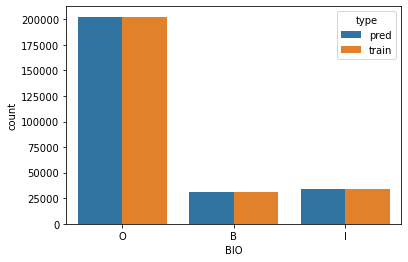

In [7]:
sns.countplot(x='BIO', hue='type', data=df_all)

In [8]:
print(f"In preds, the ratio of #Neg(O) and #Pos(B,I) is {preds['BIO'].value_counts()['O']/(preds['BIO'].value_counts()['B']+preds['BIO'].value_counts()['I'])}")
print(f"In golds, the ratio of #Neg(O) and #Pos(B,I) is {golds['BIO'].value_counts()['O']/(golds['BIO'].value_counts()['B']+golds['BIO'].value_counts()['I'])}")

In preds, the ratio of #Neg(O) and #Pos(B,I) is 3.120545833012104
In golds, the ratio of #Neg(O) and #Pos(B,I) is 3.12397956821654


#### 2.2 #O VS #problem VS #test VS #treatment

In [9]:
df_all

,word,label,BIO,class,type
0,032890433,O,O,O,pred
1,CTMC,O,O,O,pred
2,75066875,O,O,O,pred
3,828710,O,O,O,pred
4,02/21/1991,O,O,O,pred
...,...,...,...,...,...
267233,(,O,O,O,train
267234,End,O,O,O,train
267235,of,O,O,O,train
267236,Report,O,O,O,train


<AxesSubplot:xlabel='class', ylabel='count'>

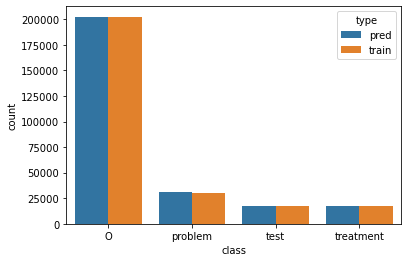

In [10]:
sns.countplot(x='class', hue='type', data=df_all)

In [11]:
n_preds = preds['class'].value_counts()['problem'] + preds['class'].value_counts()['test'] + preds['class'].value_counts()['treatment']
n_golds = golds['class'].value_counts()['problem'] + golds['class'].value_counts()['test'] + golds['class'].value_counts()['treatment']
print(f"Proportions of different entity class in preds: PROBLEM {(preds['class'].value_counts()['problem']/n_preds):.2%}, TEST {(preds['class'].value_counts()['test']/n_preds):.2%}, TREATMENT {(preds['class'].value_counts()['treatment']/n_preds):.2%}")
print(f"Proportions of different entity class in golds: PROBLEM {(golds['class'].value_counts()['problem']/n_golds):.2%}, TEST {(golds['class'].value_counts()['test']/n_golds):.2%}, TREATMENT {(golds['class'].value_counts()['treatment']/n_golds):.2%}")

Proportions of different entity class in preds: PROBLEM 47.50%, TEST 26.17%, TREATMENT 26.34%
Proportions of different entity class in golds: PROBLEM 46.71%, TEST 26.60%, TREATMENT 26.69%


- There is imbalance in the classes. The PROBLEM class takes the majority. We could seek the help from Dice Loss, which is a soft version of f1-score that can possibly help narrows down the gap between the f1-score in evalutaion and loss in training

#### 2.3 frequency of different classes in the false positives and false negatives

In [12]:
df_p[70:90]

,word,label,BIO,class,type
70,a,B-problem,B,problem,pred
71,complex,I-problem,I,problem,pred
72,left,I-problem,I,problem,pred
73,renal,I-problem,I,problem,pred
74,mass,I-problem,I,problem,pred
75,.,O,O,O,pred
76,A,B-test,B,test,pred
77,computerized,I-test,I,test,pred
78,tomography,I-test,I,test,pred
79,scan,I-test,I,test,pred


In [13]:
def capture_lines(df, column):
    """
    get sentences/entities in list of list
    """
    sep_list = list(df[df["word"] == "."].index)
    last_sep = 0
    list_sent = []
    for _, x in enumerate(sep_list):
        sentence = list(df[column][last_sep : x+1])
        list_sent.append(sentence)
        last_sep = x+1
    return list_sent

In [14]:
sents_p = capture_lines(df_p, "word")
sents_g = capture_lines(df_g, "word")
sents_t = capture_lines(df_t, "word")
ents_p = capture_lines(df_p, "label")
ents_g = capture_lines(df_g, "label")
ents_t = capture_lines(df_t, "label")
# example
print("example sentence: ", " ".join(sents_g[70]))
print("example entities: ",ents_g[70])

example sentence:  7. Neurology : Head ultrasound on day of life seven showed no intraventricular hemorrhage .
example entities:  ['O', 'O', 'O', 'B-test', 'I-test', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'I-problem', 'O']


In [15]:
# test the f1-score, precesion, recall with seqeval/sklearn/self-implemented methods
f1_score(ents_g, ents_p)

0.864204581508979

In [41]:
# def tp_fp_fn_lenient(y_true, y_pred, suffix, *args):
# lenient score
y_true = ents_g
y_pred = ents_p
suffix = None
entities_true = defaultdict(set)
entities_pred = defaultdict(set)
for type_name, start, end, _ in get_entities(y_true, suffix):
    entities_true[type_name].add((start, end))
for type_name, start, end, _ in get_entities(y_pred, suffix):
    entities_pred[type_name].add((start, end))
target_names = sorted(set(entities_true.keys()) | set(entities_pred.keys()))

tp_sum = np.array([], dtype=np.int32)
pred_sum = np.array([], dtype=np.int32)
true_sum = np.array([], dtype=np.int32)
for type_name in target_names:

    entities_true_type = sorted(entities_true.get(type_name, set()))
    entities_pred_type = sorted(entities_pred.get(type_name, set()))
    tp = 0
    for idt, xt in enumerate(entities_true_type):
        for idp, xp in enumerate(entities_pred_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                tp += 1
                break
    tp_sum = np.append(tp_sum, tp)
    pred_sum = np.append(pred_sum, len(entities_pred_type))
    true_sum = np.append(true_sum, len(entities_true_type))
    fp_sum = pred_sum - tp_sum
    fn_sum = true_sum - tp_sum

    # return pred_sum, tp_sum, true_sum

In [15]:
nw = np.append(fp_sum,fn_sum)

In [16]:
df_error = pd.DataFrame(columns=['class', 'count', 'type'])
# # df_error['type'] = "fp"
# df_error = pd.concat((df_error, pd.DataFrame(fn_sum.reshape(1,-1), columns=['problem', 'test', 'treatment'])), axis=0, ignore_index=True)
# # df_error.at[1,'type'] = "fn"
# df_error = df_error.rename(index={0:'fp',1:'fn'})
df_error['class'] = ['problem','test','treatment','problem','test','treatment']
df_error['count'] = nw
df_error['type'] = ['FP','FP','FP','FN','FN','FN']
df_error

,class,count,type
0,problem,1327,FP
1,test,1093,FP
2,treatment,1040,FP
3,problem,885,FN
4,test,998,FN
5,treatment,926,FN


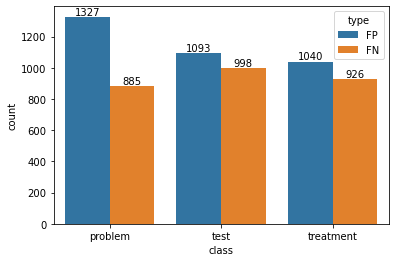

In [17]:
plots = sns.barplot(x='class', y='count',hue='type',data=df_error)
# Iterrating over the bars one-by-one to add annotations
for bar in plots.patches:
    plots.annotate(format(int(bar.get_height())),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

In [18]:
print(f"Proportions of different entity class in False Positives: PROBLEM {(fp_sum[0]/fp_sum.sum()):.2%}, TEST {(fp_sum[1]/fp_sum.sum()):.2%}, TREATMENT {(fp_sum[2]/fp_sum.sum()):.2%}")
print(f"Proportions of different entity class in False Negatives: PROBLEM {(fn_sum[0]/fn_sum.sum()):.2%}, TEST {(fn_sum[1]/fn_sum.sum()):.2%}, TREATMENT {(fn_sum[2]/fn_sum.sum()):.2%}")

Proportions of different entity class in False Positives: PROBLEM 38.35%, TEST 31.59%, TREATMENT 30.06%
Proportions of different entity class in False Negatives: PROBLEM 31.51%, TEST 35.53%, TREATMENT 32.97%


- The model tends to predict more "problem" entities while the "test" entities are harder to be detected

#### 2.4 unique entities in test_gold and train set

In [16]:
def entity_label_pair(ents, sents):
    entity_label = []
    for i, line in enumerate(ents):
        tmp_ent = []
        for j, e in enumerate(line):
            if e != 'O':
                tmp_ent.append(sents[i][j])
                lbl = e.split('-')[1]
            elif tmp_ent:
                entity_label.append((' '.join(tmp_ent),lbl))
                tmp_ent = []
    return entity_label

In [17]:
ent_label_p = entity_label_pair(ents_p, sents_p)
ent_label_g = entity_label_pair(ents_g, sents_g)
ent_label_t = entity_label_pair(ents_t, sents_t)

In [18]:
df_entity_g = pd.DataFrame(data=ent_label_g, columns=['entity', 'class'])
cnt_g = df_entity_g.value_counts().reset_index(name='count')
df_entity_p = pd.DataFrame(data=ent_label_p, columns=['entity', 'class'])
cnt_p = df_entity_p.value_counts().reset_index(name='count')

In [19]:
df_entity_t = pd.DataFrame(data=ent_label_t, columns=['entity', 'class'])
cnt_t = df_entity_t.value_counts().reset_index(name='count')
cnt_t

,entity,class,count
0,pain,problem,41
1,hypertension,problem,37
2,nausea,problem,36
3,creatinine,test,36
4,shortness of breath,problem,35
...,...,...,...
7569,a &quot; tumor &quot;,problem,1
7570,Zyrtec,treatment,1
7571,Zithropren,treatment,1
7572,Ziprasidone,treatment,1


#### 2.5 Entity Coverage Ratio (ECR)
- Describe the degree to which entities in the test set have been seen in the training set with the same category.

In [30]:
df_common = pd.merge(cnt_t, cnt_g, on=['entity','class'], how='right', indicator='Exist')
df_overlap = df_common[df_common['Exist']=='both']
df_overlap

,entity,class,count_x,count_y,Exist
0,pain,problem,41.0,101,both
1,creatinine,test,36.0,89,both
2,hypertension,problem,37.0,80,both
3,edema,problem,29.0,78,both
4,nontender,problem,29.0,77,both
...,...,...,...,...,...
15167,a low grade temperature,problem,1.0,1,both
15184,a left ventricular ejection fraction,test,1.0,1,both
15199,a mean,test,1.0,1,both
15235,a lumbar puncture,test,1.0,1,both


In [38]:
unique_entities = df_overlap['entity'].unique()
df_metrics = pd.DataFrame(columns=['entity', 'count_t', 'count_g', 'ECR'])
for i, ent in enumerate(unique_entities):
    df = df_overlap[df_overlap['entity']==ent]
    c_tr = df['count_x'].sum()
    c_te = df['count_y'].sum()
    tho = (df['count_x'].mul(df['count_y']).sum())/(c_tr*c_te)
    df_metrics.loc[i] = [ent, c_tr, c_te, tho]
df_metrics['freq_g'] = df_metrics['count_g']/df_metrics['count_g'].sum()
df_metrics

,entity,count_t,count_g,ECR,freq_g
0,pain,42.0,104,0.948718,0.007252
1,creatinine,36.0,89,1.000000,0.006206
2,hypertension,37.0,80,1.000000,0.005579
3,edema,29.0,78,1.000000,0.005439
4,nontender,29.0,77,1.000000,0.005370
...,...,...,...,...,...
2443,a low grade temperature,1.0,1,1.000000,0.000070
2444,a left ventricular ejection fraction,1.0,1,1.000000,0.000070
2445,a mean,1.0,1,1.000000,0.000070
2446,a lumbar puncture,1.0,1,1.000000,0.000070


#### 2.6 Expectation of Entity Coverage Ratio (EECR)
- Measures the degree to which the test entities have been seen in the training set. A higher value is suggestive of a larger proportion of entities with high coverage ratio.

In [26]:
EECR = (df_metrics['ECR']*df_metrics['freq_g']).sum()
print(f"EECR = {EECR}")

EECR = 0.9937100794997624


#### 2.7 Contextual Coverage Ratio (CCR)
- measure the contextual similarity of entities belonging to the same category but from the training and the test sets, respectively.

In [104]:
print(sents_g[70])
print(ents_g[70])

['7.', 'Neurology', ':', 'Head', 'ultrasound', 'on', 'day', 'of', 'life', 'seven', 'showed', 'no', 'intraventricular', 'hemorrhage', '.']
['O', 'O', 'O', 'B-test', 'I-test', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'I-problem', 'O']


In [39]:
def find_context(seq_sents, seq_ents, ws):
    """
    seq_sents: list of sentences
    seq_ents: list of entities
    return context_true: dictionry of context within problem/text/treatment categories
    """
    seqs = [item for _, sublist in enumerate(seq_sents) for item in sublist + ['O']] # record the label items

    suffix = None
    context_true = dict()
    context_true['problem'] = []
    context_true['test'] = []
    context_true['treatment'] = []
    for type_name, start, end, _ in get_entities(seq_ents, suffix):
        context = seqs[start-ws:end+ws]
        context_true[type_name].append(context)
    return context_true


In [40]:
# find context
context_tr = find_context(sents_t, ents_t,ws=3)
context_te = find_context(sents_g, ents_g,ws=3)

In [130]:
# get bigrams and trigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder_t2 = BigramCollocationFinder.from_documents(context_tr['problem'])
finder_t3 = TrigramCollocationFinder.from_documents(context_tr['problem'])
scores_t2 = finder_t2.score_ngrams(bigram_measures.raw_freq)
scores_t3 = finder_t3.score_ngrams(trigram_measures.raw_freq)
score_t = (sorted((score for _, score in scores_t3),reverse=True)[0:20])/np.array(sorted((score for _, score in scores_t3),reverse=True)).sum()
score_t = np.append(score_t, (sorted((score for _, score in scores_t2),reverse=True)[0:30])/np.array(sorted((score for _, score in scores_t2),reverse=True)).sum(), 0)
t = finder_t3.nbest(trigram_measures.raw_freq, 20)
t.extend(finder_t2.nbest(bigram_measures.raw_freq, 30))

finder_g2 = BigramCollocationFinder.from_documents(context_te['problem'])
finder_g3 = TrigramCollocationFinder.from_documents(context_te['problem'])
scores_g2 = finder_g2.score_ngrams(bigram_measures.raw_freq)
scores_g3 = finder_g3.score_ngrams(trigram_measures.raw_freq)
score_g = (sorted((score for _, score in scores_g3),reverse=True)[0:20])/np.array(sorted((score for _, score in scores_g3),reverse=True)).sum()
score_g = np.append(score_g, (sorted((score for _, score in scores_g2),reverse=True)[0:30])/np.array(sorted((score for _, score in scores_g2),reverse=True)).sum(), 0)
g = finder_g3.nbest(trigram_measures.raw_freq, 20)
g.extend(finder_g2.nbest(bigram_measures.raw_freq, 30))

In [34]:
# get word vectors
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def get_context_vectors(lst):
    joint_lst = []
    for contxt in lst:
        joint_lst.append(" ".join(contxt))
    encoded = tokenizer(joint_lst, padding=True)
    input_ids = torch.tensor(encoded.input_ids)
    out = model(input_ids)
    vectors = out.last_hidden_state.mean(dim=1)
    return vectors

In [36]:
vector_tr = get_context_vectors(t)
vector_te = get_context_vectors(g)

In [133]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out = 0
for i, input1 in enumerate(vector_tr):
    for j, input2 in enumerate(vector_tr):
        sim = cos(input1.unsqueeze(dim=0), input2.unsqueeze(dim=0))
        out += score_t[i]*score_g[j]*sim

In [134]:
out

tensor([0.0197], grad_fn=<AddBackward0>)

### 3. Locate the error sentences

In [111]:
# get the FN and FP dictionaries and save
y_true = ents_g
y_pred = ents_p
suffix = None
entities_true = defaultdict(set)
entities_pred = defaultdict(set)

for type_name, start, end, (sent_id, ent_id) in get_entities(y_true, suffix):
    entities_true[type_name].add((start, end, (sent_id, ent_id)))
for type_name, start, end, (sent_id, ent_id) in get_entities(y_pred, suffix):
    entities_pred[type_name].add((start, end, (sent_id, ent_id)))
target_names = sorted(set(entities_true.keys()) | set(entities_pred.keys()))

fn = dict()
fp = dict()
for type_name in target_names:

    entities_true_type = sorted(entities_true.get(type_name, set()))
    entities_pred_type = sorted(entities_pred.get(type_name, set()))
    fn[type_name] = []
    fp[type_name] = []

    for idt, xt in enumerate(entities_true_type):
        mark_match = -1
        for idp, xp in enumerate(entities_pred_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                mark_match = idp
                break
        if idp == len(entities_pred_type)-1 and mark_match == -1:
            fn[type_name].append(xt)
    
    for idp, xp in enumerate(entities_pred_type):
        mark_match = -1
        for idt, xt in enumerate(entities_true_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                mark_match = idt
                break
        if idt == len(entities_true_type)-1 and mark_match == -1:
            fp[type_name].append(xp)

In [107]:
with open('./analysis_2010/fp.json', 'wb') as f:
    pickle.dump(fp, f)
with open('./analysis_2010/fn.json', 'wb') as f:
    pickle.dump(fn, f)

In [102]:
error_id = 4
sent_id = fn['problem'][error_id][2][0]
print(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl'))

| We | think | this | is | likely | due | to | an          | SIADH       | as | she | is | euvolemic | . |
| O  | O     | O    | O  | O      | O   | O  | B-problem   | I-problem   | O  | O   | O  | O         | O |
| O  | O     | O    | O  | O      | O   | O  | B-treatment | I-treatment | O  | O   | O  | B-problem | O |


In [77]:
check_fn = pd.DataFrame([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]])
check_fn = check_fn.rename(index={0:'sentence',1:'gold',2:'pred'})
check_fn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
sentence,We,think,this,is,likely,due,to,an,SIADH,as,she,is,euvolemic,.
gold,O,O,O,O,O,O,O,B-problem,I-problem,O,O,O,O,O
pred,O,O,O,O,O,O,O,B-treatment,I-treatment,O,O,O,B-problem,O


In [143]:
for error_id in range(len(fn['problem'])):
    sent_id = fn['problem'][error_id][2][0]
    ent_id = fn['problem'][error_id][2][1]
    with open("./analysis_2010/fn_analysis/fn_tabular_"+str(sent_id)+".txt", "a") as text_file:
        text_file.write(f"FN in entity {ent_id} \n")
        text_file.write(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl')+'\n')

In [145]:
for error_id in range(len(fp['problem'])):
    sent_id = fp['problem'][error_id][2][0]
    ent_id = fp['problem'][error_id][2][1]
    with open("./analysis_2010/fp_analysis/fp_tabular_"+str(sent_id)+".txt", "a") as text_file:
        text_file.write(f"FP in entity {ent_id} \n")
        text_file.write(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl')+'\n')